# CMPINF 0010 Final Project
---
In this final project, our team has been tasked to find the best neighborhood in Pittsburgh through our own metrics.

## Metric 1 - Arrest/Crime Data
---
One of the first metrics that our group thought of was safety, no matter what the benefits of a neighborhood are, if there is a high crime rate. In order to get measurable metric, I needed to import the Pittsburgh arrests CSV file and count the number of times a crime was committed in certian neighborhood in order to calculate crime rates for each neighborhood.

The first step is displayed below:

<AxesSubplot:>

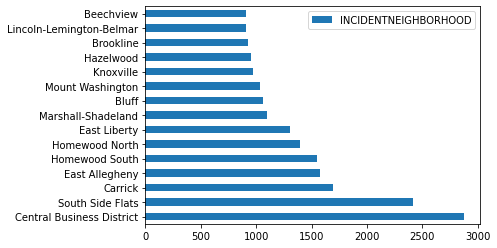

In [328]:
import pandas as pd
import geopandas
%matplotlib inline
import matplotlib.pyplot as plt #allows you to manipulate plot, can use interface to generate plot

arrests = pd.read_csv("CSVs/Arrests.csv")

numArrests = pd.DataFrame(arrests["INCIDENTNEIGHBORHOOD"].value_counts(ascending = False))


numArrests.head(15).plot.barh()

After counting my data, I needed to import data from a separate CSV on population data for the neighborhoods in Pittsburgh. I then need to merge the population data in this new dataframe with the numArrests dataframe and divide the number of arrests by the population and multiply by 10,000 to find the crime rate per 10,000 people.

In [329]:
hoodInfo = pd.read_csv("CSVs/total-population.csv", index_col = "Neighborhood")

numArrests["INCIDENTNEIGHBORHOOD"].astype(object)

# arrestAndPop = numArrests.merge(hoodInfo, how = "right", 
#                                 left_on = "INCIDENTNEIGHBORHOOD", 
#                                 right_on = "Neighborhood",)

Central Business District    2877
South Side Flats             2414
Carrick                      1693
East Allegheny               1578
Homewood South               1549
                             ... 
Central Northside              23
Regent Square                  23
Mt. Oliver Boro                17
Troy Hill-Herrs Island          6
Mt. Oliver Neighborhood         2
Name: INCIDENTNEIGHBORHOOD, Length: 98, dtype: object

## Metric 2 - Older Housing Data 
---
Another metric that our group thought of was how old are the houses between the neighborhoods. Older housing is found to be unpleasant and also dangerous. 

Older houses with household lead paint and contaminated lead waters cause more exposure to lead which is a neurotoxin that can result in serious health problems, especially for pregnant women and children. It has been shown to affect IQ, ability to pay attention, academic achievement, and other behavioral issues.


In [330]:
#tract is the number of the tract 
#pre1950 represents the percent of homes in each census tract that were built on or before 1950
house_percent_data = pd.read_csv("CSVs/pre1950housing.csv")
#house_percent_data


In [331]:
house_percent_data['TRACT'].dtypes
house_percent_data.rename({'TRACT': 'Census Tracts'}, axis=1, inplace=True)
house_percent_data


,Census Tracts,Pre1950
0,10300,0.658477
1,20100,0.321088
2,20300,0.724907
3,30500,0.324117
4,40200,0.463549
...,...,...
388,980000,0.353982
389,980100,0.000000
390,980700,0.619048
391,981100,0.000000


In [332]:
#neighborhoods corresponding the tract numbers
tract = pd.read_csv("CSVs/Pittsburgh_Census_Tracts_2010.csv")
tract.head()

,Neighborhood,Census Tracts
0,Allegheny Center,562700
1,Allegheny West,562700
2,Allentown,180300
3,Arlington,561600
4,Arlington Heights,561600


In [333]:
tract['Neighborhood'] = tract['Neighborhood'].astype('string') 
#tract['Neighborhood'].dtypes
tract['Census Tracts'] = tract['Census Tracts'].astype('string') 
#tract['Census Tracts'].dtypes

In [334]:
tract['Census Tracts'] = tract['Census Tracts'].str.split(', ')
tract_data =tract.explode('Census Tracts', ignore_index=True)
tract_data['Census Tracts'] = pd.to_numeric(tract_data['Census Tracts'])
#tract_data['Census Tracts'].dtypes
tract_data.head(50)


,Neighborhood,Census Tracts
0,Allegheny Center,562700
1,Allegheny West,562700
2,Allentown,180300
3,Arlington,561600
4,Arlington Heights,561600
5,Banksville,202300
6,Bedford Dwellings,50900
7,Beechview,191600
8,Beltzhoover,562400
9,Bloomfield,80200


In [335]:
old_house_data=pd.merge(house_percent_data, tract_data, on='Census Tracts')
old_house_data.head()

,Census Tracts,Pre1950,Neighborhood
0,10300,0.658477,Bluff
1,20100,0.321088,Golden Triangle/Civic Arena
2,20300,0.724907,Strip District
3,30500,0.324117,Crawford-Roberts
4,40200,0.463549,Terrace Village


In [336]:
#the data on percent venous confirmed elevated blood lead levels (EBLLs)(≥5 μg/dL)
#for Allegheny County children less than 6 years of ageby assigned geography for 2015-2019
lead_data = pd.read_csv("CSVs/Blood_Lead_Level_Rates.csv")
lead_data.head()

,SchoolDistrict,percentEBLL2015,note2015,percentEBLL2016,note2016,percentEBLL2017,note2017,percentEBLL2018,note2018,percentEBLL2019,note2019,percentEBLL15_19,note15_19
0,Allegheny Valley,0.00,"Unstable percent, interpret with caution",0.00,"Unstable percent, interpret with caution",0.92,"Unstable percent, interpret with caution",0.68,"Unstable percent, interpret with caution",0.00,"Unstable percent, interpret with caution",0.43,"Unstable percent, interpret with caution"
1,Avonworth,0.72,"Unstable percent, interpret with caution",0.75,"Unstable percent, interpret with caution",0.55,"Unstable percent, interpret with caution",0.89,"Unstable percent, interpret with caution",2.00,"Unstable percent, interpret with caution",1.15,NaN
2,Baldwin-Whitehall,0.91,"Unstable percent, interpret with caution",0.59,"Unstable percent, interpret with caution",1.40,NaN,1.42,NaN,0.49,"Unstable percent, interpret with caution",1.05,NaN
3,Bethel Park,0.00,"Unstable percent, interpret with caution",0.00,"Unstable percent, interpret with caution",0.61,"Unstable percent, interpret with caution",0.18,"Unstable percent, interpret with caution",0.89,"Unstable percent, interpret with caution",0.51,"Unstable percent, interpret with caution"
4,Brentwood Borough,1.60,"Unstable percent, interpret with caution",1.35,"Unstable percent, interpret with caution",3.45,"Unstable percent, interpret with caution",2.68,"Unstable percent, interpret with caution",2.54,"Unstable percent, interpret with caution",2.46,NaN


## Metric 3 - 
---

## Conclusion
---